***
LIBRARIES: most required ones
***

In [90]:
from tqdm import tqdm # progress bar
import matplotlib.pyplot as plt # plot


import torch # pytorch
import torch.nn as nn # neural network
import torch.optim as optim # optimizer
from torchsummary import summary # model summary (architecture)
from torch.utils.data import DataLoader, random_split # dataloader, dataset split
from torchvision import transforms,datasets, utils # image processing, datasets
import torchvision.models as models # pretrained models
import numpy as np # numpy
DATA_PATH = './dataset'

***
DATA LOADING
***

In [92]:
#Transformation for image
transform_ori = transforms.Compose([transforms.RandomResizedCrop(128),   #create 64x64 image
                                    transforms.RandomHorizontalFlip(),    #flipping the image horizontally
                                    transforms.ToTensor(),                 #convert the image to a Tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #normalize the image
                                    
dataset = datasets.ImageFolder(root = DATA_PATH, transform=transform_ori)
data_size = len(dataset)

In [93]:
test_size = int(data_size * 0.20)
train_size = data_size - test_size
generator = torch.Generator().manual_seed(42)
training, testing = random_split(dataset, [train_size, test_size], generator=generator)

In [94]:
batch_size = 32

# Training DataLoader
train_load = DataLoader(
    dataset=training,
    batch_size=batch_size,
    shuffle=True
)

# Testing DataLoader
test_load = DataLoader(
    dataset=testing,
    batch_size=batch_size,
    shuffle=False
)

In [95]:
classes = ('cloudy','foggy','rainy','shine','sunrise')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


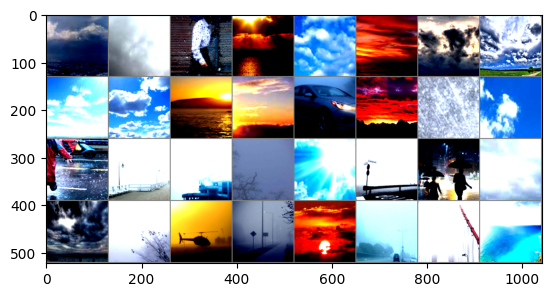

cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy


In [96]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_load)
images, labels = next(dataiter)

# show images
imshow(utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

***
ARCHITECTURE DEFINING
***

In [97]:
# Create a neural net class
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=5):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lastcnn = nn.Linear(in_features=64 * 64 * 64, out_features=5)   
        self.relu=nn.ReLU()    

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x) 
        x = x.view(x.size(0), -1)    
        x = self.relu(self.lastcnn(x))  # Move ReLU after the fully connected layer
        return torch.log_softmax(x, dim=1)
    
   
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

model = Net(num_classes=5).to(device)

***
OBJECTS: CRITERION, OPTIMIZER, SCHEDULER(maybe)
***

In [98]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

***
TRAINING AND VALIDATION: Validation not neccessary but recommended
***

In [99]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [100]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0.0
    total_batches = len(train_loader)

    print("Epoch:", epoch)

    # Process the images in batches
    for i, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} / {}: Loss: {:.6f}'.format(i + 1, total_batches, loss.item()))
    
    # Calculate average loss for the epoch
    avg_loss = train_loss / total_batches
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    
    return avg_loss

In [101]:
epoch_nums = []
training_loss = []
validation_loss = []

epochs = 5
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_load, optimizer, epoch)
        test_loss = test(model, device, test_load)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
	Training batch 1 / 38: Loss: 1.553749
	Training batch 2 / 38: Loss: 186.758148
	Training batch 3 / 38: Loss: 68.288628
	Training batch 4 / 38: Loss: 14.012205
	Training batch 5 / 38: Loss: 180.930664
	Training batch 6 / 38: Loss: 21.707174
	Training batch 7 / 38: Loss: 2.550647
	Training batch 8 / 38: Loss: 17.432274
	Training batch 9 / 38: Loss: 11.920782
	Training batch 10 / 38: Loss: 5.158678
	Training batch 11 / 38: Loss: 4.534639
	Training batch 12 / 38: Loss: 0.880208
	Training batch 13 / 38: Loss: 0.452654
	Training batch 14 / 38: Loss: 3.126386
	Training batch 15 / 38: Loss: 0.352065
	Training batch 16 / 38: Loss: 5.780843
	Training batch 17 / 38: Loss: 0.402359
	Training batch 18 / 38: Loss: 0.201180
	Training batch 19 / 38: Loss: 0.213164
	Training batch 20 / 38: Loss: 2.386198
	Training batch 21 / 38: Loss: 0.953123
	Training batch 22 / 38: Loss: 0.653834
	Training batch 23 / 38: Loss: 0.352065
	Training batch 24 / 38: Loss: 0.452654
	Training batch

***
PLOTTING: Loss & Accuracy
***

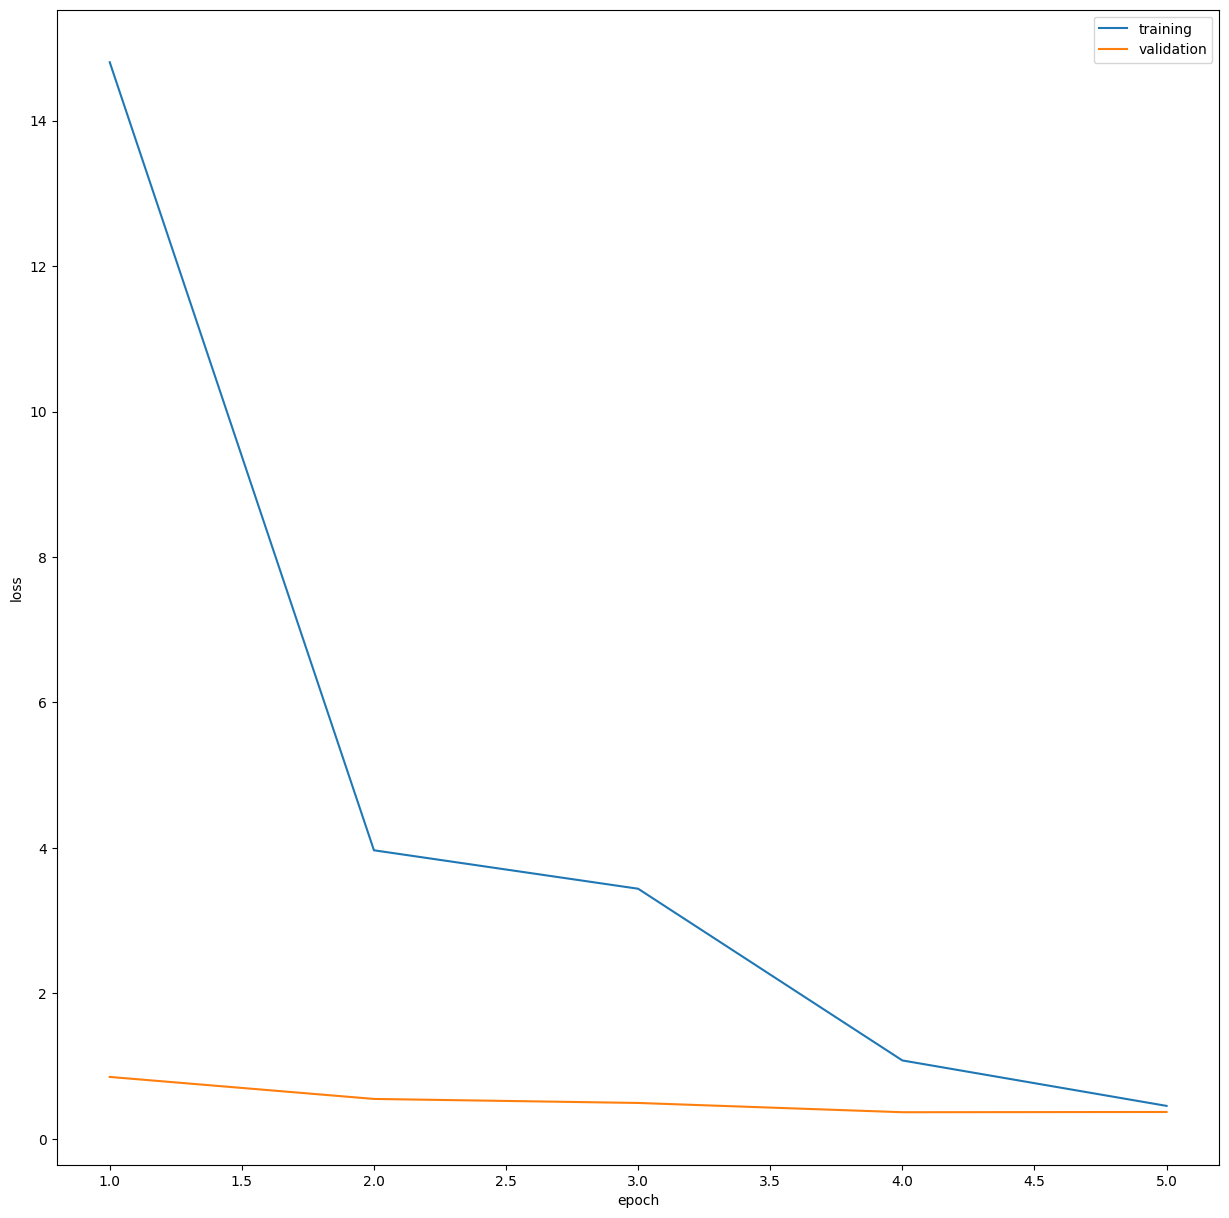

In [102]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

***
SAVING
***

In [103]:
width,height = 128,128
x = torch.Tensor(1, 3, width, height)
with torch.no_grad():
    traced_cell = torch.jit.trace(model, (x))
model_name = "./models/C_team2.pt" # CHANGE THIS TO YOUR OWN PATH (most improtatnt step)
torch.jit.save(traced_cell, model_name)


# torch.save () this is not allowed because it requires class definition before loading for the 
# model evaluation